# A simple Product Recommendation process based on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. Once we have the results, I'll first visually inspect the results and then analyze results (recommendations in this case) based on the descriptions.

### Motivation for this project and practical application

Any decent recommender model would have been trained using data from millions of products. For companies like Amazon, such large amounts of data is easy to come by. But that's not all now is it? Can the same recommender model be used for years at a stretch without any modifications? Probably not. Products evolve over time. Companies do away with older products and bring in  newer ones every day. Companies like Amazon have the time and resources to ensure that their recommendation systems are up to date with the latest trends.

Moreover, neural networks are being used for recommender systems. These models are designed using sophisticated state of the art architecture. The model needs to be designed first. Then it will be tested and modified again and again. Fine tuning deep learning models can be a monumental task. Now, what if I told you that we could come up with a decent recommender process that involves no training at all? Sounds too good to be true? Well, thanks to __[Google's universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ , this is possible! Given a product description as text, the input will be mapped to a high dimensional vector of length 512. These "embeddings" are then used to compute similarities based on which practical recommendations can be made

### Concepts before deep dive

Please refer to this __[jupyter notebook](https://github.com/adjakka/Springboard_Capstone_Projects/blob/master/Capstone_2/notebooks/Concepts_explained.ipynb)__ for a simple breakdown of some of the concepts, inner workings of embeddings ans how they contribute to developing semantic relationships between words/sentences.

### Outline of the steps in this file:

- Convert the descriptions column to a list and have that run through __[Tensorflow's Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ . This computes a numpy array of length 512 for each movie plot.
2. Calculate the cosine similarities matrix using the above generated numpy array for the 9 most similar product descriptions.
3. Plot the images of the products using the url in the source file.
4. Analyze genres and possibly the plot descriptions as well.

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
new_df = pd.read_csv('office_products.csv')

In [3]:
#Inspecting the structure of the file
new_df.head()

imUrl  \
0  http://ecx.images-amazon.com/images/I/31GQFtyz...   
1  http://ecx.images-amazon.com/images/I/31XtfnUA...   
2  http://ecx.images-amazon.com/images/I/31TefcCO...   
3  http://ecx.images-amazon.com/images/I/41Kl5-GQ...   
4  http://ecx.images-amazon.com/images/I/41VRHMGF...   

                                               title  \
0                        EGP Income Tax Return Cover   
1  Compatible Magenta High Capacity Epson Toner C...   
2                iPaperPad - a paper pad not an iPad   
3  Pratt PRA0076 Recycled Corrugated Cardboard Si...   
4  GE Cordless 900 MHz 26943GE2 Phone with Call W...   

                                         description  \
0  Item TAXCVR610\n\nUse this tax return cover fo...   
1  Compatible Magenta High Capacity Epson Toner C...   
2  The iPaperPad is not magical or revolutionary....   
3                                                NaN   
4  900 MHz 26943GE2The proven technology of 900 M...   

                                     description_new  
0  Item TAXCVR610\n\nUse this tax return cover fo...  
1  Compatible Magenta High Capacity Epson Toner C...  
2  The iPaperPad is not magical or revolutionary....  
3                                                NaN  
4  900 MHz 26943GE2The proven technology of 900 M...

In [4]:
len(new_df)

69896

We will now only choose the fields of interest

In [5]:
new_df = new_df.dropna()

In [6]:
len(new_df)

67823

In [7]:
new_df = new_df.reset_index(drop=True)

In [8]:
len(new_df)

67823

The index will be reset by ignoring the old indices.

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [10]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [11]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [12]:
all_descriptions = new_df['description_new'].tolist()

In [13]:
len(all_descriptions)

67823

In [14]:
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:20000]
set_3 = all_descriptions[20000:30000]
set_4 = all_descriptions[30000:40000]
set_5 = all_descriptions[40000:50000]
set_6 = all_descriptions[50000:60000]
set_7 = all_descriptions[60000:]
#set_7 = all_descriptions[70000]
final_set = [set_1, set_2, set_3, set_4, set_5, set_6, set_7]

In [15]:
tf.logging.set_verbosity(tf.logging.ERROR)
j = 0
for i in final_set:
    j+=1
    with tf.device('/device:CPU:0'):  
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i))
            np.save('office_set' + str(j) + '.npy', description_embeddings)            

In [16]:
office_set_1 = np.load('office_set1.npy')
office_set_2 = np.load('office_set2.npy')
office_set_3 = np.load('office_set3.npy')
office_set_4 = np.load('office_set4.npy')
office_set_5 = np.load('office_set5.npy')
office_set_6 = np.load('office_set6.npy')
office_set_7 = np.load('office_set7.npy')

In [17]:
full_set = np.concatenate([office_set_1, office_set_2, office_set_3, office_set_4, office_set_5, office_set_6, office_set_7])

In [18]:
len(full_set)

67823

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [19]:
description_embeddings = full_set

In [20]:
cos_matrix = cosine_similarity(description_embeddings)

In [21]:
cos_matrix.shape

(67823, 67823)

The cosine similarities matrix is a square matrix since the cosine similarity of each and every pair of elements is computed.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [24]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [25]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = cos_matrix[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        plt.xticks([])
        plt.yticks([])
        j+=1

Before we begin seeing results right away, let us inspect th product in query.

I've added code to record the index number of the suggested product descriptions.

In [10]:
new_df['title'].loc[645]

'Hand-turned Amboyna Burl Pen with Retractable Ballpoint and Gold Fittings'

In [9]:
new_df['description'].loc[645]

'A memorable gift or special treat for yourself.  \n\nThis hand-turned pen, made of Amboyna burl, is the creation of an American craftsman from the Pacific Northwest.  \n\nA beautiful writing instrument, this pen has a retractable ballpoint, with gold fittings and a pocket clip.  It is slightly thicker than average pen, allowing a more relaxed grip.  It is also a comfortable fit for the larger hand or those with arthritis.  It comes packaged in an elegant blue velveteen gift box with white satin lining.  Included is a description of the materials used.  Length is 5 inches, diameter approx. 1/2 inch.  Made in the U.S.'

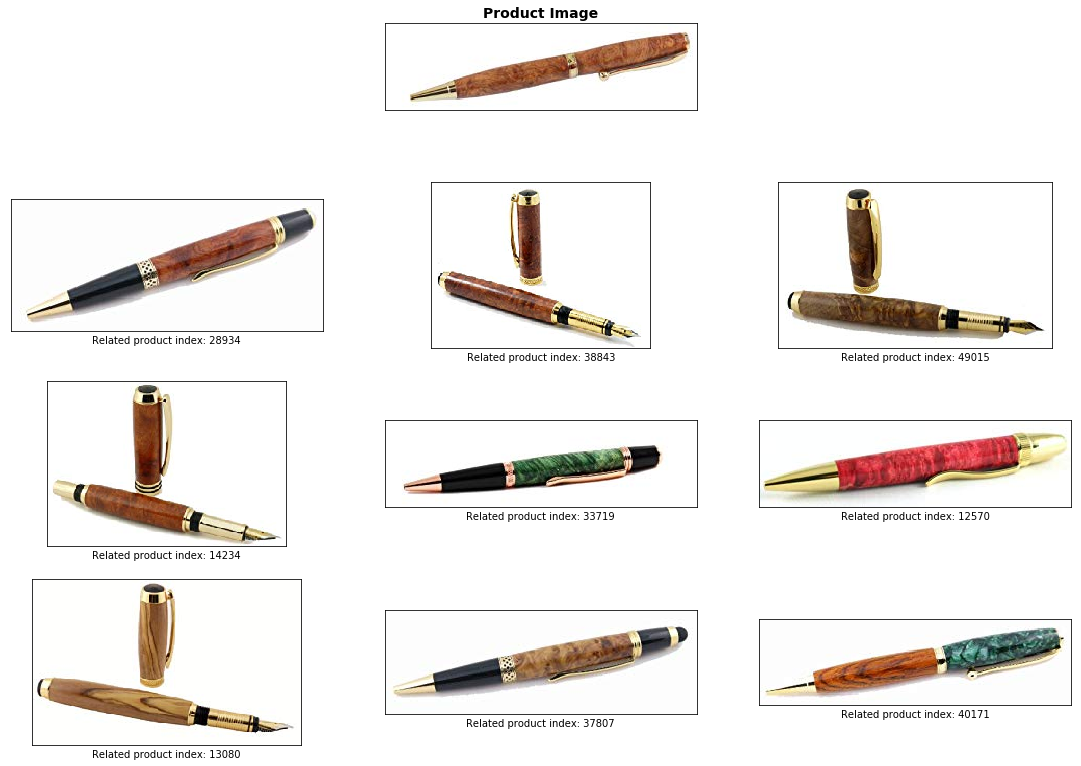

In [28]:
get_related_products(645)

Looking at the above results, we can see that we got very similar products. All of these pens happen to have gold fittings.

In [11]:
new_df['title'].loc[8823]

'BAZIC 21-Gram 0.7-Ounce Large Glue Stick, 3 Pack'

What we have here is a pack of glue stick.

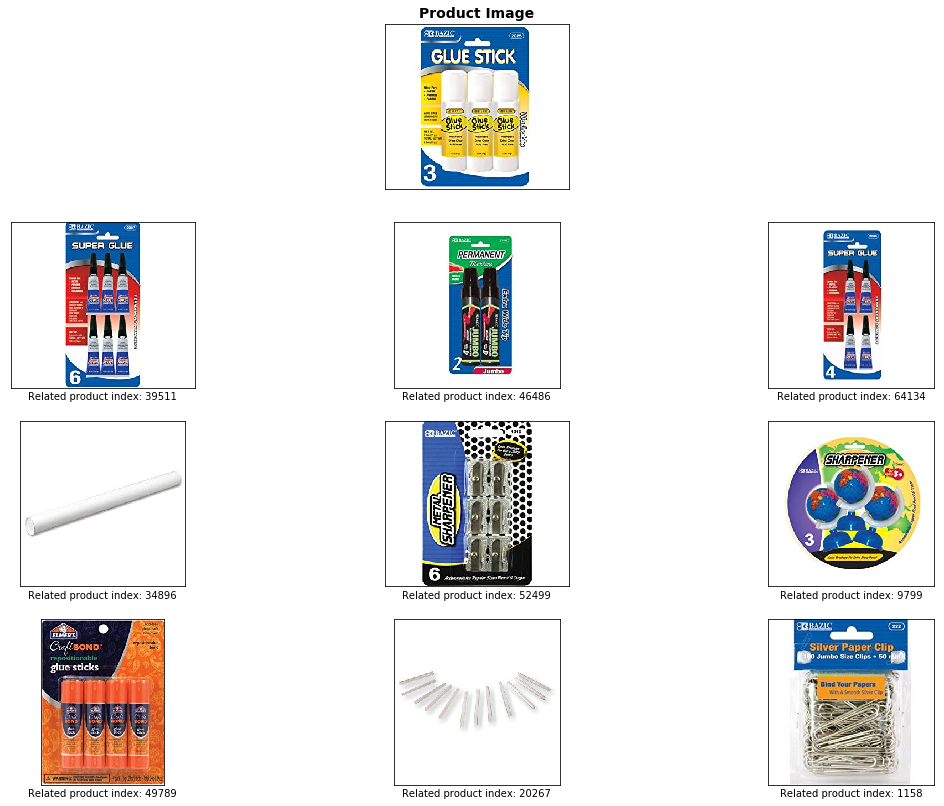

In [34]:
get_related_products(8823)

In [14]:
nums = [34896, 9799, 1158]

In [15]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

34896 Quality Park White Kraft Fiberboard Mailing Tubes

9799 BAZIC Globe Sharpener, 3 Inch, 3 Per Pack

1158 BAZIC Jumbo Paper Clip, 50 mm, Silver, 100 Per Pack



We not only got other glue sticks but we got a pencil sharpener, a mailing tube (we'll see what this is in just a second) and also a paper clip.

In [16]:
new_df['description'].loc[34896]

'Quality Park Mailer Storage Tube - 36" - Removable End Caps - Fiberboard, Kraft - 25/Carton - White'

Hence, we can see that it we're getting items in the context of stationary items!

In [49]:
new_df['title'].loc[16847]

"BININBOX Men's Leather Black Bifold Zip AROUND Wallet Purse Card holder"

We have a mens' wallet here.

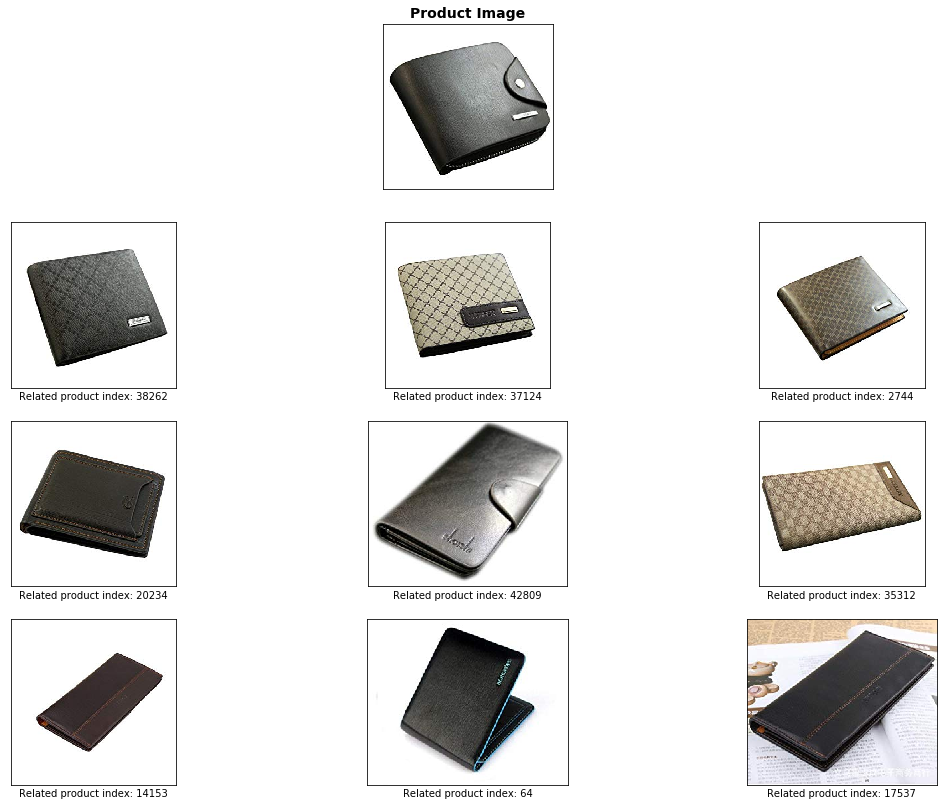

In [50]:
get_related_products(16847)

Sure enough, we get other wallets. It's also important to note once again that we aren't being shows any wallets here but the descriptions will be accounted for. For example, if it's a leather wallet, we'll be shown other leather wallets. Or, if we have wallets from a certain company, we'll be other wallets from the same company and so forth.

In [17]:
new_df['title'].loc[14405]

'Fellowes Steel Mail Cart, 150 Legal Sized File Folder Capacity,  39.0 Inches High x 20.0 Inches Wide x 40.5 Inches Deep, Dove Gray (40922)'

We have a mail cart here. Let's check out the recommended products.

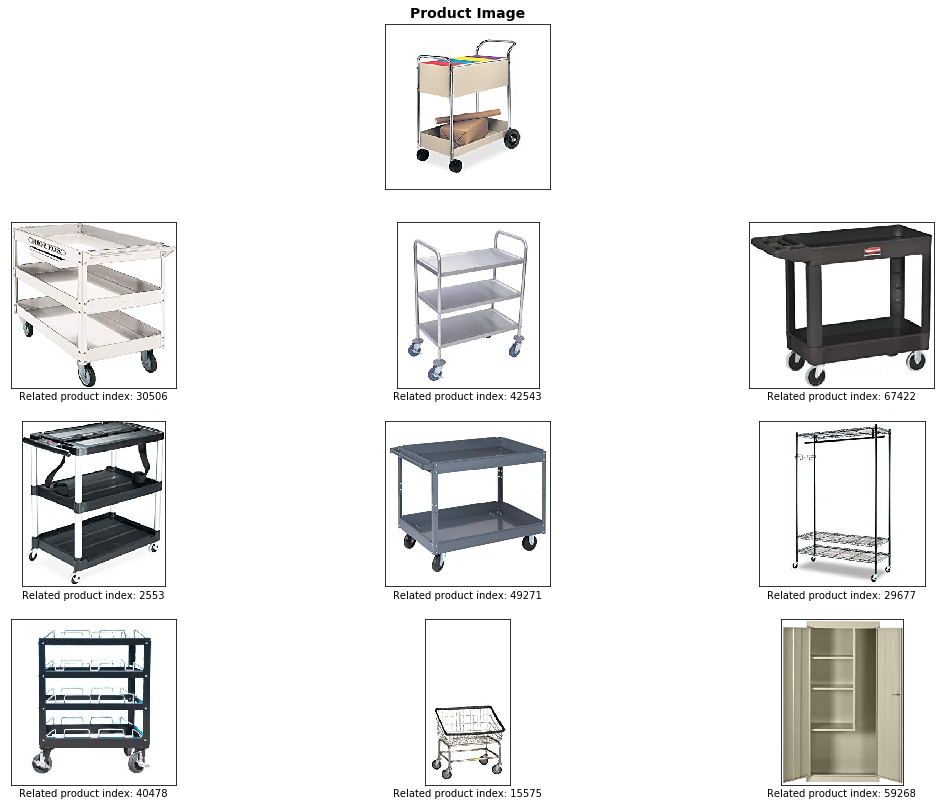

In [57]:
get_related_products(14405)

In [18]:
nums = [2553, 29677, 59268]

In [19]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

2553 Rubbermaid 9T28 Black Media Master AV Cart with Three Shelves

29677 Alera Wire Shelving Garment Rack (Black)

59268 Sandusky Lee VFC1301566-07 Putty Steel Powder Coat Janitorial/Supply Cabinet with Cam Locking System, 66&quot; Height x 30&quot; Width x 15&quot; Depth, 3 Shelves



Product 2553 is indeed a cart with. We also got a garment rack. The last result is a little odd and we probably didn't expect to see it. Why did this happen? The module has learnt to associate "racks" with shelves" and in this context, it returned the last result.

In [61]:
new_df['title'].loc[60297]

'Panasonic KX-T7730 Telephone Black'

We have a cordless Panasonic telephone. Popular products of the early part of the decade and immensely popular during the last decade. Let's check out the results.

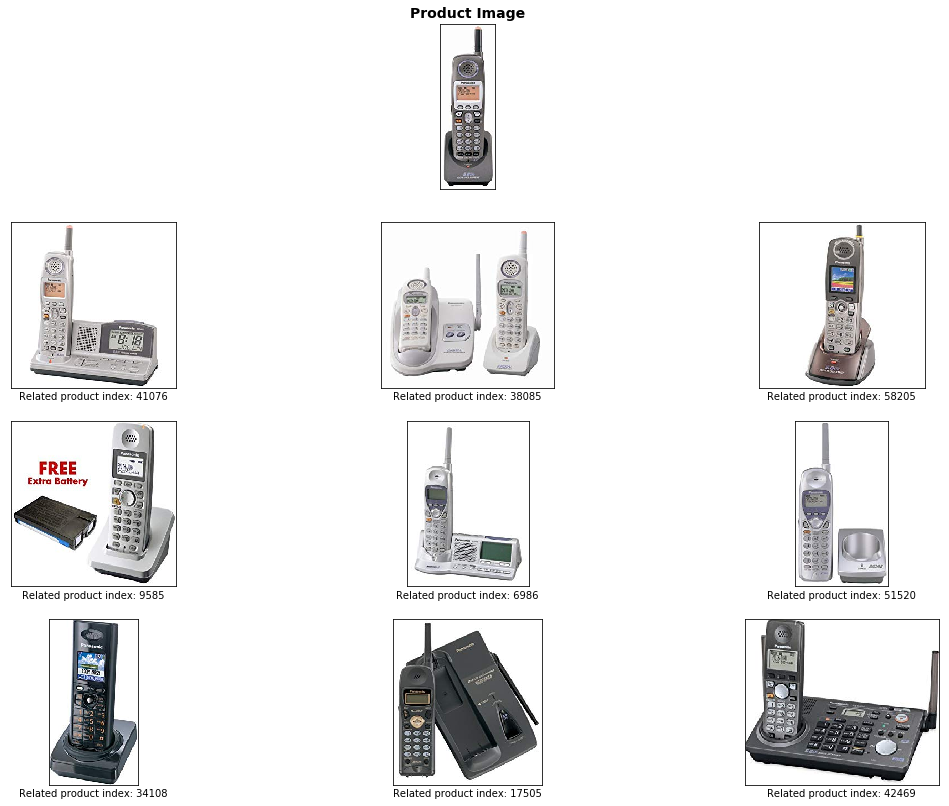

In [63]:
get_related_products(36226)

In [69]:
new_df['title'].loc[36143]

'Metrologic MS 7120 Orbit - Barcode Scanner (K34269) Category: Barcode Scanners'

So, we have a barcode scanner here.

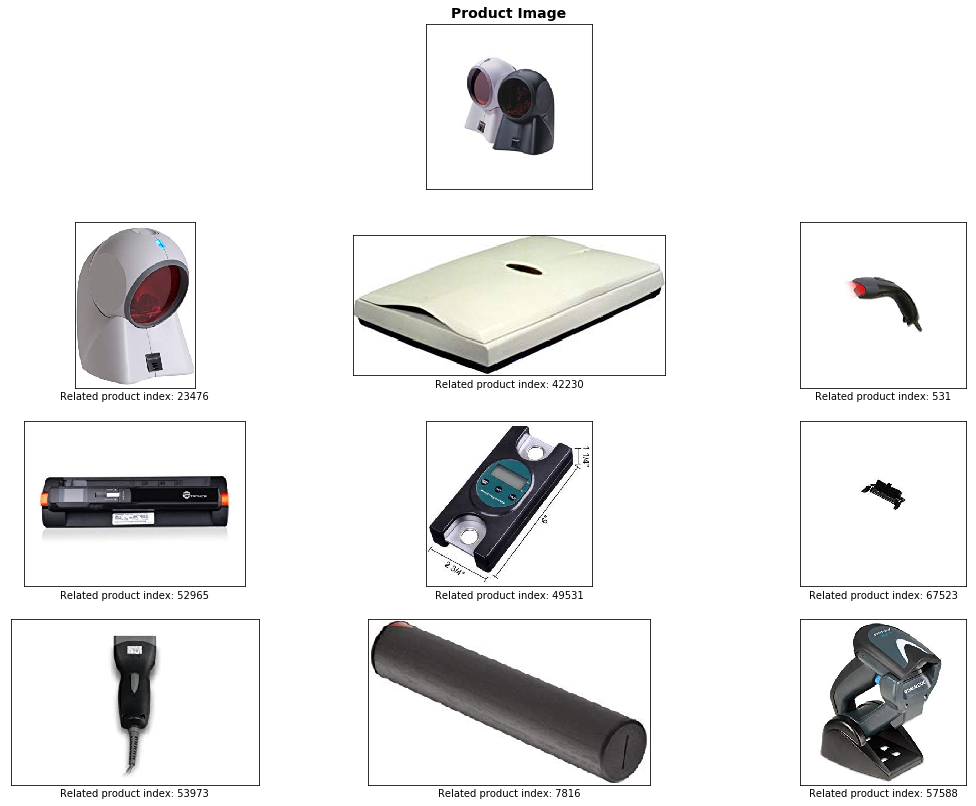

In [68]:
get_related_products(36143)

In [21]:
nums = [42230, 52965, 49531, 67523, 7816]

In [22]:
for j in nums:
    print(str(j) + ' ' + new_df['title'].loc[j] + '\n')

42230 Mustek PlugnScan 1200CP Scanner

52965 TaoTronics TT-DS004 2-in-1 900 DPI 1.4' TFT Color Display Colour &amp; Mono Handyscan Handheld Scanner for Document, Photo, Reciepts, Books + JPG/PDF Format Selection Black&#65288;Micro SD Card included as free gift&#65289;

49531 Easy Handle Industrial Business Portable Digital Electronic Hanging Scale With Digit backlit LCD display

67523 Separation Pad for P-150

7816 3B Scientific U21875 Plastic Budget Hand Held Spectroscope



An interesting result. We got a few barcode scanners. But we also got a document scanner, a digital hanging scale, a separation pad (used with printers) and a spectroscope! While it has generalized scanners and printers, the spectroscope was not an intended result. Let's check out the description of this product and see if we can make intuitive sense for this result

In [24]:
new_df['description_new'].loc[7816]

'Hand spectroscope. An uncomplicated yet still fully functional spectroscope for observing spectra and spectral lines. This model is made of cardboard and plastic with built in grid. Measures 28mm diameter by 145mm length.'

The only was this came up could be because this device, like the barcode scanner is a hand held device!

In [25]:
new_df['title'].loc[1937]

'OSP Designs 166006-3 SpaceFlex Task Chair'

We have an ergonomic office chair.

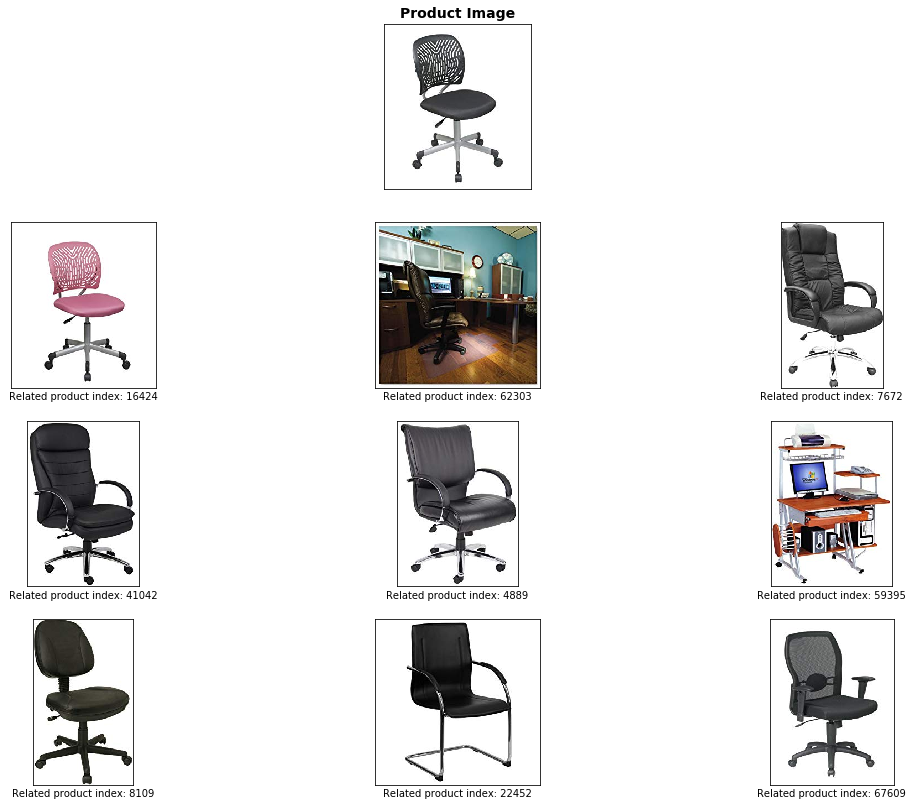

In [74]:
get_related_products(1937)

We get other ergonomic chairs and also a computer table!

In [80]:
new_df['title'].loc[19296]

'Canon L-50 Compatible Toner Replaces L50 Laser Toner'

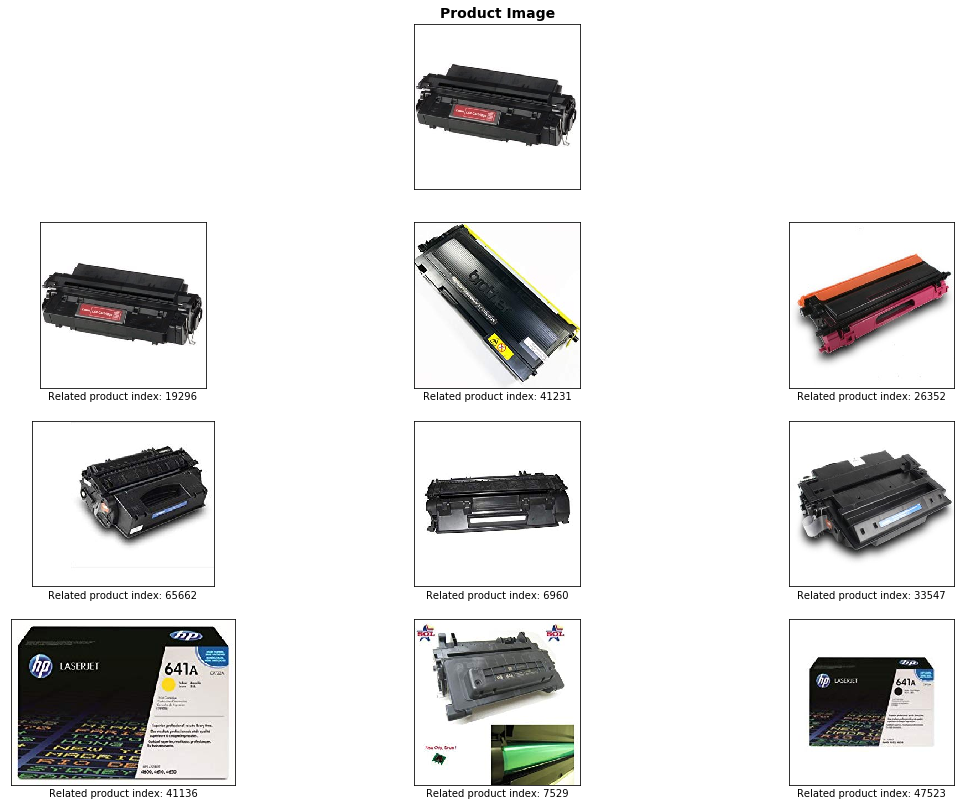

In [81]:
get_related_products(19296)

In [79]:
new_df['title'].loc[2260]

'Comfort Products 60-6810 Leather Executive Chair with 5-Motor Massage, Thick pillow-top seat cushions, Soft bonded leather upholstery, Padded PP armrests with nylon base, Tilt, tension, lock, swivel, pneumatic lift height adjust, 5 vibration massage motors relax the back and thighs, 5 hour rechargeable battery and built-in controller'

In [85]:
new_df['title'].loc[41307]

'DYMO 1772057 Digital Postal Scale / Shipping Scale, 10-pound'

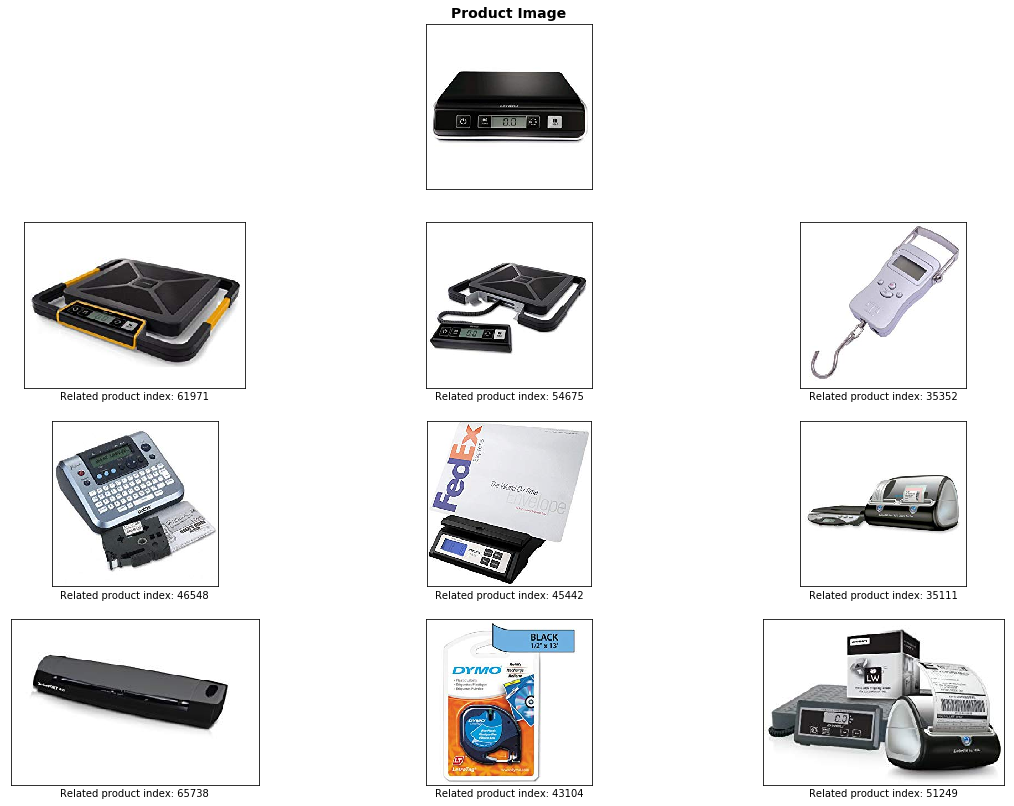

In [84]:
get_related_products(41307)

In [86]:
new_df['title'].loc[8888]

'Universal 43313 1/3-Cut Hanging File Folder Plastic Index Tabs (25 per Pack)'

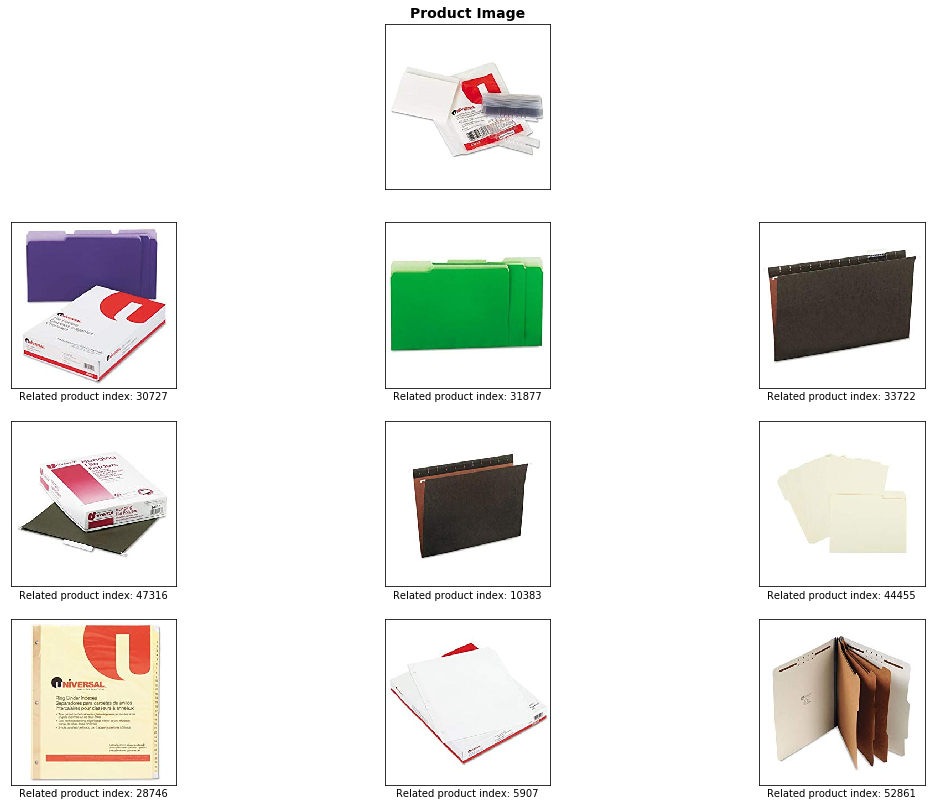

In [87]:
get_related_products(8888)

In [92]:
new_df['title'].loc[13246]

'Desk Saver File Holder Accessory'

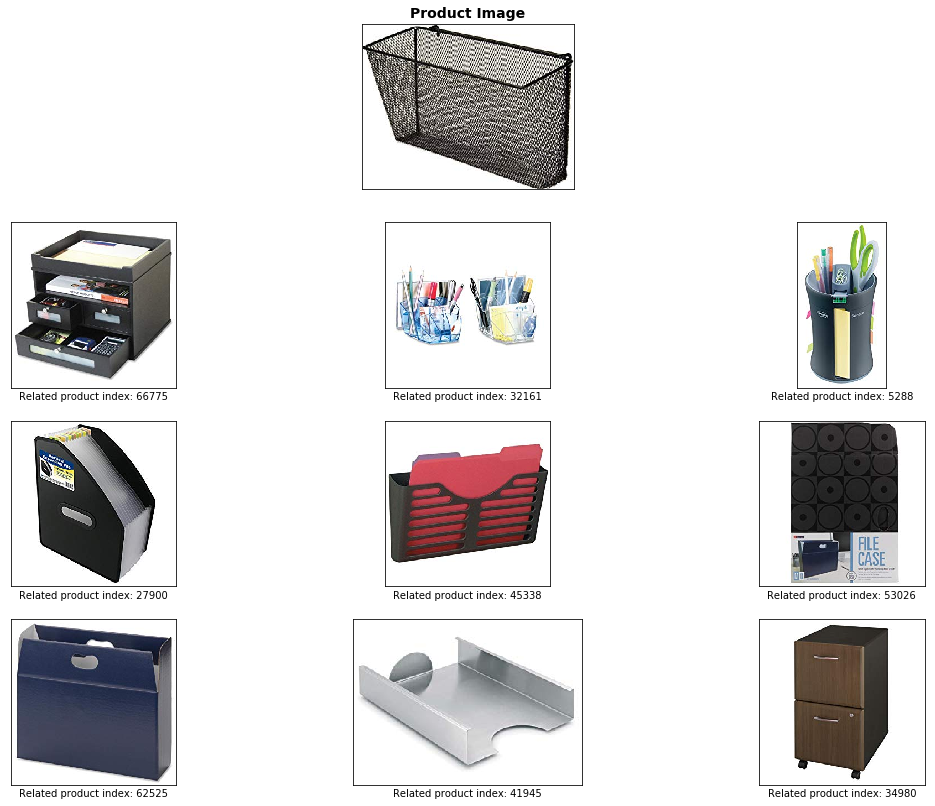

In [91]:
get_related_products(13246)